## Import

In [136]:
import h5py
import os
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import (accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, 
                             recall_score, confusion_matrix, precision_recall_curve, auc, 
                             average_precision_score)
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.feature_selection import mutual_info_classif
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score


from tensorflow.keras.layers import (GlobalAveragePooling2D, BatchNormalization, Input, Conv2D, 
                                     MaxPooling2D, UpSampling2D, Dense, Reshape, Flatten, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import warnings
warnings.filterwarnings("ignore")


## caricamento dati

In [137]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )


h5_file_path = '../images_by_patient_final.h5'
loaded_class_images=[]

with h5py.File(h5_file_path, 'r') as h5_file:
    loaded_class_images = {key: np.array(h5_file[key]) for key in h5_file.keys()}

loaded_class_images= {int(key.split('_')[1]): images for key, images in loaded_class_images.items()}

print("Lunghezza array immagini: ", len(loaded_class_images))
print("Shape immagini primo paziente: ", loaded_class_images[0].shape)
print("Shape immagini secondo paziente: ", loaded_class_images[1].shape)




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]
Lunghezza array immagini:  129
Shape immagini primo paziente:  (28, 64, 64)
Shape immagini secondo paziente:  (

## encoder

### righe filtrate per area

In [64]:
import zipfile
import pandas as pd
import numpy as np

# Percorso del file .npy
file_path = "../indici_aree/aree_05.npy"
arraytuple = np.load(file_path)

# Converti il primo elemento di ogni tupla in int
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

# Percorso del file zip
zip_file_path = "../CSV/EncodersAllSlices/RESNET50_ALL_SLICES.zip"

# Apri il file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Ottieni il nome del file CSV dentro lo zip
    csv_filename = zip_ref.namelist()[0]
    # Leggi il file CSV direttamente dalla memoria
    with zip_ref.open(csv_filename) as csv_file:
        data = pd.read_csv(csv_file)

# Droppa l'ultima colonna
data = data.drop(data.columns[-1], axis=1)

# Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di arraytuple
filtered_data = data[
    data.apply(lambda row: any((row['Patient'] == (t[0]) and row['Slice'] == t[1]) for t in arraytuple), axis=1)
]

# Filter columns that start with 'original' or 'dentro'
filtered_patients = []

for patient_id in loaded_patients:
    # Filter the data for the specific patient
    filtered_patient_data = filtered_data[filtered_data['Patient'] == patient_id]
    
    # Dopo aver filtrato per paziente, rimuovi le prime due colonne ('Patient' e 'Slice')
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    
    slices = []
    
    for _, slice_row in filtered_patient_data.iterrows():
        # Select only the filtered columns for each slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    filtered_patients.append(slices)

# Stampa per verificare che le prime due colonne siano state rimosse
print(filtered_patient_data.head())


      Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
2808   2.377326   3.274636   2.013952   0.275560   2.394179   5.385625   
2809   2.482739   4.068787   0.810608   1.547340   6.818315   2.987768   
2810   1.114671   1.998824   0.634478   0.249409   7.153679   4.489606   
2811   8.704536   8.171625   1.522603   2.454735   4.428733   3.896485   
2812  11.740080   6.855061   1.964360   1.960793   5.232543   5.534787   

      Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_2038  \
2808   1.583958   3.567320   0.533475   0.527079  ...      0.166958   
2809   0.000000   0.908637   1.671802   0.000000  ...      0.000000   
2810   0.000000   0.107862   0.000000   0.000000  ...      0.000000   
2811   0.342597   0.332982   0.000000   0.156167  ...      0.000000   
2812   0.514283   2.683876   1.274759   0.000000  ...      0.000000   

      Feature_2039  Feature_2040  Feature_2041  Feature_2042  Feature_2043  \
2808      6.080950      7.087179      1.102882    

### righe non filtrate

In [352]:
import zipfile
# Percorso del file zip
zip_file_path = "../CSV/EncodersAllSlices/RESNET50_ALL_SLICES.zip"

# Apri il file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Ottieni il nome del file CSV dentro lo zip
    csv_filename = zip_ref.namelist()[0]  # Se c'è un solo file, puoi usare il primo
    # Leggi il file CSV direttamente dalla memoria
    with zip_ref.open(csv_filename) as csv_file:
        data = pd.read_csv(csv_file)

data = data.drop(data.columns[-1], axis=1)

# Filter columns that start with 'original' or 'dentro'
patients = []

for patient_id in loaded_patients:

    # Filter the data for the specific patient
    patient_data = data[data['Patient'] == patient_id]
    
    slices = []
    
    for _, slice_row in patient_data.iterrows():
        # Select only the filtered columns for each slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    patients.append(slices)


Colonne del DataFrame:
Index(['Patient', 'Slice', 'Feature_0', 'Feature_1', 'Feature_2', 'Feature_3',
       'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7',
       ...
       'Feature_2038', 'Feature_2039', 'Feature_2040', 'Feature_2041',
       'Feature_2042', 'Feature_2043', 'Feature_2044', 'Feature_2045',
       'Feature_2046', 'Feature_2047'],
      dtype='object', length=2050)


In [375]:
print(len(patients))
print(len(patients[0][0]))
print(len(patients[1]))
print(len(patients[2]))

129
2050
36
49


In [381]:
print(len(filtered_patients))
print(len(filtered_patients[0][0]))
print(len(filtered_patients[1]))
print(len(filtered_patients[2]))

129
2050
17
27


## radiomica


### righe non filtrate

In [ ]:
# Load the data
file_path = "../CSV/EncodersAllSlices/Radiomica_Wavelet_25D.csv.zip"
data = pd.read_csv(file_path)

# Filter columns that start with 'original'
filtered_columns = [col for col in data.columns if col.startswith('original')]

patients = []

for patient_id in loaded_patients:

    # Filter the data for the specific patient
    patient_data = data[data['Paziente'] == patient_id]
    
    slices = []
    
    for _, slice_row in patient_data.iterrows():
        # Select only the filtered columns for each slice
        slice_features = slice_row[filtered_columns].tolist()
        
        # Check for NaN values in the slice, and only append if there are no NaNs
        if not any(np.isnan(value) for value in slice_features):
            slices.append(slice_features)
    
    patients.append(slices)

# Optional: Check if all slices with NaN were removed successfully
for i, patient in enumerate(patients):
    for j, slice_features in enumerate(patient):
        assert not any(np.isnan(value) for value in slice_features), f"NaN found in patient {i}, slice {j}"

print("All slices with NaN values have been removed.")


### righe per slice 0.5

In [144]:
import zipfile
import pandas as pd

file_path = "../indici_aree/aree_05.npy"
arraytuple = np.load(file_path)

# Converti il primo elemento di ogni tupla in int
arraytuple = [(int(t[0]), t[1], t[2]) for t in arraytuple]

zip_file_path = "../CSV/EncodersAllSlices/Radiomica_Wavelet_25D.csv.zip"

# Apri il file zip e leggi il CSV direttamente dalla memoria
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Ottieni il nome del file CSV dentro lo zip
    csv_filename = zip_ref.namelist()[0]  # Se c'è un solo file, puoi usare il primo
    # Leggi il file CSV direttamente dalla memoria
    with zip_ref.open(csv_filename) as csv_file:
        data = pd.read_csv(csv_file)

# Filtra il DataFrame per mantenere solo le righe che corrispondono agli elementi di arraytuple
filtered_data = data[
    data.apply(lambda row: any((row['Paziente'] == (t[0]) and row['Slice'] == t[1]) for t in arraytuple), axis=1)
]

# Filter columns that start with 'original' or 'dentro'
filtered_patients = []

for patient_id in loaded_patients:
    # Filter the data for the specific patient
    filtered_patient_data = filtered_data[filtered_data['Paziente'] == patient_id]
    
    # Rimuovi le prime due colonne ('Paziente' e 'Slice')
    filtered_patient_data = filtered_patient_data.drop(filtered_patient_data.columns[:2], axis=1)
    
    # Rimuovi le colonne che iniziano con "diagnostics"
    filtered_patient_data = filtered_patient_data.filter(regex='^(?!diagnostics).*')

    slices = []
    
    for _, slice_row in filtered_patient_data.iterrows():
        # Select only the filtered columns for each slice
        slice_features = slice_row.tolist()
        slices.append(slice_features)
    
    filtered_patients.append(slices)

# Stampa per verificare che le colonne "diagnostics" siano state rimosse
print(filtered_patient_data.head())


      original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
5173                     0.671066                         27.415337   
5174                     0.682877                         27.791993   
5175                     0.702334                         28.459397   
5176                     0.690099                         29.293440   
5177                     0.670387                         30.390451   

      original_shape2D_MaximumDiameter  original_shape2D_MeshSurface  \
5173                         25.495098                         235.0   
5174                         26.400758                         265.0   
5175                         28.301943                         315.0   
5176                         29.681644                         360.0   
5177                         31.064449                         400.0   

      original_shape2D_MinorAxisLength  original_shape2D_Perimeter  \
5173                         18.397498                  111.982756   


In [145]:
print(len(filtered_patients))
print(len(filtered_patients[0][0]))
print(len(filtered_patients[1]))
print(len(filtered_patients[2]))

129
474
17
27


## funzioni

In [4]:
## funzione per creare array da array di array
def continue_array(filtered_patients, labels):
    all_features = []
    for patient in filtered_patients:
        for image_features in patient:
            all_features.append(image_features)

    all_features_array = np.array(all_features)
    expanded_labels = []
    expanded_patient_ids = []

    for i in range(len(filtered_patients)):
        num_images = len(filtered_patients[i])
        expanded_labels.extend([labels[i]] * num_images)
        expanded_patient_ids.extend([loaded_patients[i]] * num_images)

    expanded_labels_array = np.array(expanded_labels)
    expanded_patient_ids_array = np.array(expanded_patient_ids)

    return all_features_array, expanded_labels_array, expanded_patient_ids_array


## funzioni per feature correlation
def filter_highly_correlated_features(df, corr, threshold=0.85):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    removed_features = []

    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= threshold:
                if columns[j]:
                    columns[j] = False
                    removed_features.append(df.columns[j])

    return removed_features


def perform_correlation(z_train, y_train, numero = 32, threshold = 0.85):
    all_images, _, _= continue_array(z_train, y_train)

    df = pd.DataFrame(all_images, columns=[f'feature_{i}' for i in range(numero)])

    corr_matrix = df.corr()

    features_selected = filter_highly_correlated_features(df, corr_matrix, threshold)
    
    return features_selected

## funzione per rimuovere le features con p_value maggiore della treshold
def select_features_by_p_value(x_train_expanded, y_train_expanded, p_value_threshold=0.05):

    p_values = []
    num_features = x_train_expanded.shape[1]

    for i in range(num_features):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)

    p_values = np.array(p_values)

    selected_features_indices = np.where(p_values < p_value_threshold)[0]

    sorted_indices = selected_features_indices[np.argsort(p_values[selected_features_indices])]

    x_train_expanded = x_train_expanded[:, sorted_indices]

    return x_train_expanded, sorted_indices



## funzione per rimozione di features specifiche
def remove_features_from_patients(patients, features_to_remove):
    feature_indices_to_remove = [int(feature.split('_')[1]) for feature in features_to_remove]
    
    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.delete(image_features, feature_indices_to_remove, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))    

    return final_patients


## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=2000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def p_value_feature_selection(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## funzione per lasciare solo le features indicate per array di array
def keep_features_in_patients(patients, features_to_keep):

    feature_indices_to_keep = [int(feature) for feature in features_to_keep]

    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.take(image_features, feature_indices_to_keep, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))

    return final_patients


## funzione per lasciare solo le features indicate per array
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []
    
    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected




In [5]:
def classifierinitialization(classifier):
    if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42, max_iter=2000)
    elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
    elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42, max_iter=2000)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )
    return classi

In [22]:
## funzione per effettuarr majority voting o mean su tutte le slice di un paziente, per passare da una predizione sulla slice
## alla predizione per il paziente

def prob_to_binary(predictions_proba, patient_scores, threshold, mode):
    final_predictionarray = []          
    
    if mode == 'MV':  # Majority Voting
        for p in predictions_proba:
            test_patient_predictions = []
            for proba in p:               
                predictions_binary = 1 if proba[0][1] > threshold else 0
                test_patient_predictions.append(predictions_binary)
            count_0 = np.sum(np.array(test_patient_predictions) == 0) 
            count_1 = np.sum(np.array(test_patient_predictions) == 1)                                   
            final_prediction = 0 if count_0 > count_1 else 1
            final_predictionarray.append(final_prediction)
    
    elif mode == 'Mean':  # Mean of probabilities
        for score in patient_scores:
            predictions_binary = 1 if score > threshold else 0
            final_predictionarray.append(predictions_binary)
    
    elif mode == 'Max':  # Maximum probability across both classes
        for p in predictions_proba:
            max_proba = None
            max_slice = None

            # Itera su ogni slice per trovare la massima probabilità (indipendentemente dalla classe)
            for proba in p:
                class_0_prob = proba[0][0]  # Probabilità della classe 0
                class_1_prob = proba[0][1]  # Probabilità della classe 1
                
                # Trova la probabilità massima tra entrambe le classi per ciascuna slice
                slice_max_proba = max(class_0_prob, class_1_prob)

                # Trova la slice con la probabilità massima
                if max_proba is None or slice_max_proba > max_proba:
                    max_proba = slice_max_proba
                    max_slice = proba  # Memorizza la slice con la probabilità massima

            # Ora usa la probabilità della classe 1 della slice con la probabilità massima per il confronto con la soglia
            predictions_binary = 1 if max_slice[0][1] > threshold else 0
            final_predictionarray.append(predictions_binary)




    return final_predictionarray



def classification_method(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, modePrediction, thresholds=np.arange(0.001, 0.501, 0.001), mode = "Val", selected_features= [0]):

    #print(features_test)
    if(mode == "Val"):
            selected_features = None 
            
            if num_features != len(x_train_expanded[0]) or alpha != 0:
                if selector == "lasso":
                    X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                    if(len(selected_features)==0):
                            return 0
                elif selector == "logistic": 
                    X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "mrmr":
                    X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "rf":
                    X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector=="p_value":
                    X_selected, selected_features= p_value_feature_selection(x_train_expanded,y_train_expanded, num_features)
                else:
                    print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                    return
                
                #features_test = filter_patients_features(features_test, selected_features)
                features_test = keep_features_in_patients(features_test, selected_features)
                keep_features_in_patients
                #print(f"features_test {features_test}")
            else:
                X_selected = x_train_expanded
                selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection
            number_features = len(selected_features) 
        
            smote = SMOTE(random_state=42)

            X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
            classifier.fit(X_resampled, y_resampled)

    patient_scores=[]
    temp_array=[]

    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
    
    

    best_f1_score = 0
    best_threshold = None
    #best_precision=0
    #best_recall=0
    best_prediction=[]
    
    # Valuta le performance utilizzando diverse threshold
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    ## viene calcolata la threshold che porta a un f1 migliore e effettuata la prediction con quella
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, patient_scores, threshold, modePrediction)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                #best_precision = precision_score(y_test, binary_predictions)
                #best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore che viene passata dal validation
        best_threshold = thresholds
        best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, modePrediction)
        best_f1_score = f1_score(y_test, best_prediction)
        #best_precision = precision_score(y_test, best_prediction)
        #best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")
    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)

    #precision, recall, _ = precision_recall_curve(y_test, patient_scores) ## utili per ricostruire grafici
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)

    # Calcola la balanced accuracy
    bal_acc = balanced_accuracy_score(y_test, best_prediction)

    conf= confusion_matrix(y_test, best_prediction)


    best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': best_f1_score,
                    'accuracy': test_accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': best_threshold,
                    'balanced accuracy': bal_acc
                }
    
    return best_case

## split

In [146]:

# patients_train contiene il nome dei pazienti (5,12 etc)
# y_train contiene le labels
# features_train contiene array di array dove ogni paziente ha varie immagini rappresentate da n features

#patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.3, shuffle=False)

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, filtered_patients, test_size=0.3, shuffle=False)

print("Number of train patients: ", len(features_train1))
print("Number of test patients: ", len(features_test))


print("Number of features for every image: ", len(features_train1[0][0]) )


Number of train patients:  90
Number of test patients:  39
Number of features for every image:  474


In [160]:
alpha_res_inc = np.linspace(0.03, 0.6, 30).tolist() ## RANGE PER RESNET e INCEPETION

alpha_vgg = np.linspace(0.005, 0.5, 30).tolist() ## RANGE PER VGG

alpha_rad = np.linspace(0.05, 3, 30).tolist() ## range per radiomica


alpha_values=alpha_rad


classifiers=['RandomForest', 'Logistic', 'XgBoost',  'SVM', 'ensemble', 'MLP']
selectors=['rf', 'mrmr', 'logistic', 'lasso']
modes=['Max','Mean','MV']



In [148]:
### correlation 0.8
starting_features = len(features_train1[0][0])
features=perform_correlation(features_train1, y_train1, starting_features, 0.9)

final_patients_train1=remove_features_from_patients(features_train1, features)
final_patients_test=remove_features_from_patients(features_test, features)

print(f"correlation ha trovato {final_patients_train1[0].shape[1]} features\n")

### p-value 0.01
x_train_expanded1, y_train_expanded1, _ = continue_array(final_patients_train1, y_train1)
x_train_expanded1, sf= select_features_by_p_value(x_train_expanded1, y_train_expanded1, 0.05)
print(f"Scelte {len(sf)} features dal p_value\n")
print("x_train_expanded1", x_train_expanded1.shape)

final_patients_test=keep_features_in_patients(final_patients_test, sf)
final_patients_train1=keep_features_in_patients(final_patients_train1, sf)

print("final_patients_test", final_patients_test[0].shape)
print("final_patients_train1", final_patients_train1[0].shape)

patients_train1 = np.array(patients_train1)


correlation ha trovato 135 features

Scelte 111 features dal p_value

x_train_expanded1 (2068, 111)
final_patients_test (27, 111)
final_patients_train1 (25, 111)


## Loop results_val e test

In [163]:
template_dict = {
               'fold'
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'mode': None,
                'balanced accuracy': None
            }


results_val_others = [template_dict.copy() for _ in range(50000)]
results_val_others.append(template_dict.copy())

results_val_lasso = [template_dict.copy() for _ in range(50000)]
results_val_lasso.append(template_dict.copy())


limit=30

smote = SMOTE(random_state=10)
 
k=0

n_folds=5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=13)



In [164]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(final_patients_train1, y_train1)):
   
    print("Starting with fold:", fold_idx)

    y_train, y_val = y_train1[train_index], y_train1[val_index]
    patients_train, patients_val = patients_train1[train_index], patients_train1[val_index]
    
    final_patients_train = [final_patients_train1[i] for i in train_index]
    final_patients_val = [final_patients_train1[i] for i in val_index]
    
    
    x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

    x_train_expanded, y_train_expanded = smote.fit_resample(x_train_expanded, y_train_expanded)

    for mode in modes:
        print("Starting with mode:", mode)
        for i, classifier in enumerate(classifiers):
                print("Starting with classifier:", classifier)
                for j, selector in enumerate(selectors):
                    print("Starting with selector:", selector)

                    if(selector=='lasso'):

                        for alpha in alpha_values:
                        
                            classi= classifierinitialization(classifier)
                            
                            best_case_val = classification_method(
                                   selector, alpha, classi, x_train_expanded, y_train_expanded, 
                                   patients_val, y_val, final_patients_val, 0, mode, thresholds=0.5
                              )
                            
                            #print(f"for {alpha} found {best_case_val['num_features']} ")
                            #if(best_case_val==0 or best_case_val['num_features']> limit or best_case_val['f1']==0):
                                #continue
                                
                            if((best_case_val==0) or  (best_case_val['num_features']> limit)):
                                best_case_val['balanced accuracy'] = 0
                                best_case_val['accuracy'] = 0
                                best_case_val['f1'] = 0
                                best_case_val['roc_auc'] = 0
                                best_case_val['pr_auc'] = 0
                                best_case_val['selected_features'] = [0]
                                best_case_val['num_features'] = 0
                                best_case_val['confusion_matrix'] = 0
                            
                            results_val_lasso[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': alpha,
                                                'mode': mode,
                                                'num_features': best_case_val['num_features'],
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                                }

                            k = k + 1

                    else:
                        limit=30
                        for t in range(1, limit):
                                classi= classifierinitialization(classifier)

                                best_case_val = classification_method(
                                   selector, 0, classi, x_train_expanded, y_train_expanded, 
                                   patients_val, y_val, final_patients_val, t, mode, thresholds=0.5
                              )
                        
                                    
                                results_val_others[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': 0,
                                                'mode': mode,
                                                'num_features': t,
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                }

                                k = k + 1

Starting with fold: 0
Starting with mode: Max
Starting with classifier: RandomForest
Starting with selector: rf
Starting with selector: mrmr
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: Logistic
Starting with selector: rf
Starting with selector: mrmr
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: XgBoost
Starting with selector: rf
Starting with selector: mrmr
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: SVM
Starting with selector: rf
Starting with selector: mrmr
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: ensemble
Starting with selector: rf
Starting with selector: mrmr
Starting with selector: logistic
Starting with selector: lasso
Starting with classifier: MLP
Starting with selector: rf
Starting with selector: mrmr
Starting with selector: logistic
Starting with selector: lasso
Starting with mode: Mean
Starting wit

## dizionari

### salvo

In [ ]:
import pickle
with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/0.9_0.05/0.5 area/radiomica wavelet/results_val_lasso_Radiomica_2.5', 'wb') as pickle_file:
    pickle.dump(results_val_lasso, pickle_file)

with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/0.9_0.05/0.5 area/radiomica wavelet/results_val_others_Radiomica_2.5', 'wb') as pickle_file:
    pickle.dump(results_val_others, pickle_file)


In [ ]:
import pickle

with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/0.8_0.01/0.5 area/resnet/results_val_lasso_RESNET_2.5', 'wb') as pickle_file:
    pickle.dump(results_val_lasso, pickle_file)

with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/0.8_0.01/0.5 area/resnet/results_val_others_RESNET_2.5', 'wb') as pickle_file:
    pickle.dump(results_val_others, pickle_file)

with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/0.8_0.01/0.5 area/resnet/results_val_lasso_RESNET_2.5_Maxfinal', 'wb') as pickle_file:
    pickle.dump(results_val_lasso_max, pickle_file)

with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/0.8_0.01/0.5 area/resnet/results_val_others_RESNET_2.5_Maxfinal', 'wb') as pickle_file:
    pickle.dump(results_val_others_max, pickle_file)

In [108]:
import pickle

with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/0.9_0.05/0.5 area/inception/results_val_lasso_INCEPTION_2.5', 'wb') as pickle_file:
    pickle.dump(results_val_lasso, pickle_file)

with open('/Users/alessiamenozzi/Desktop/dizionari 2.5/0.9_0.05/0.5 area/inception/results_val_others_INCEPTION_2.5', 'wb') as pickle_file:
    pickle.dump(results_val_others, pickle_file)

### apro

In [122]:
import pickle
with open("/Users/alessiamenozzi/Desktop/dizionari 2.5/0.9_0.05/0.5 area/resnet/results_val_lasso_RESNET_2.5", 'rb') as file:
    results_val_lasso = pickle.load(file)

with open("/Users/alessiamenozzi/Desktop/dizionari 2.5/0.9_0.05/0.5 area/resnet/results_val_others_RESNET_2.5", 'rb') as file:
    results_val_others = pickle.load(file)

## valutazione migliori

In [123]:
#results_test_lasso = [entry for entry in results_test_lasso if entry['classifier'] is not None]
#print(f"Filtered results_test_lasso: {len(results_test_lasso)} entries remaining")
results_val_lasso= [entry for entry in results_val_lasso if entry['selector'] is not None]
print(f"Filtered results_val_lasso: {len(results_val_lasso)} entries remaining")
#results_test_others = [entry for entry in results_test_others if entry['classifier'] is not None]
#print(f"Filtered results_test_others: {len(results_test_others)} entries remaining")
results_val_others = [entry for entry in results_val_others if entry['selector'] is not None]
print(f"Filtered results_val_others: {len(results_val_others)} entries remaining")

Filtered results_val_lasso: 2700 entries remaining
Filtered results_val_others: 7830 entries remaining


### sorting dei risultati

In [124]:
import statistics

num_features_range = list(range(1, 30))

grid_results_others = {}
grid_results_lasso = {}

selectors = ['mrmr', 'rf', 'logistic']

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            for mode in modes:
            #print(f"Sto iniziando selector {selector}")
                for num_features in num_features_range:
                        
                        # Filtra i risultati che corrispondono a questa combinazione di parametri
                        filtered_results=[]
                        for res in results_val_others:
                            ## qui filtro per num_features
                            if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features and res['mode']==mode):
                                filtered_results.append(res)
                    
                        if filtered_results:
                            f1_values = [res['f1'] for res in filtered_results]
                            balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                            roc_values=[res['roc_auc'] for res in filtered_results]

                            # Calcola le medie delle metriche
                            avg_f1 = sum(f1_values) / len(f1_values)
                            avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                            avg_roc = sum(roc_values) / len(roc_values)

                            # Calcola la deviazione standard delle metriche
                            std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                            std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                            std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                            # Memorizza i risultati medi e la deviazione standard di questa combinazione
                            grid_results_others[(classifier, selector, num_features, mode)] = {
                                'avg_f1': avg_f1,
                                'std_f1': std_f1,
                                'avg_balaccuracy': avg_balaccuracy,
                                'std_balaccuracy': std_balaccuracy,
                                'avg_roc_auc': avg_roc,
                                'std_roc_auc': std_roc_auc
                            }



## ORA PER LASSO
selectors = ['lasso']
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        for mode in modes:
            #print(f"Sto iniziando selector {selector}")
            for alpha in alpha_values:
                    filtered_results = []
                    for res in results_val_lasso:
                        ## qui filtro per alpha
                        if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha and res['mode']==mode):
                            filtered_results.append(res)

                    if filtered_results:
                            f1_values = [res['f1'] for res in filtered_results]
                            balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                            roc_values=[res['roc_auc'] for res in filtered_results]

                            # Calcola le medie delle metriche
                            avg_f1 = sum(f1_values) / len(f1_values)
                            avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                            avg_roc = sum(roc_values) / len(roc_values)

                            # Calcola la deviazione standard delle metriche
                            std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                            std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                            std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                            # Memorizza i risultati medi e la deviazione standard di questa combinazione
                            grid_results_lasso[(classifier, selector, alpha, mode)] = {
                                'avg_f1': avg_f1,
                                'std_f1': std_f1,
                                'avg_balaccuracy': avg_balaccuracy,
                                'std_balaccuracy': std_balaccuracy,
                                'avg_roc_auc': avg_roc,
                                'std_roc_auc': std_roc_auc,
                            }


# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']), reverse=True)

#sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']),reverse=True)
#sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']), reverse=True)


In [125]:
import functools

# Funzione di ordinamento personalizzata
def compare_items(item1, item2):
    balacc1 = item1[1]['avg_balaccuracy']
    balacc2 = item2[1]['avg_balaccuracy']
    
    # Se la differenza tra le balanced accuracies è minore di 0.001, confronta la ROC AUC
    if abs(balacc1 - balacc2) < 0.002:
        roc_auc1 = item1[1]['avg_roc_auc']
        roc_auc2 = item2[1]['avg_roc_auc']
        # Confronta la ROC AUC e ritorna -1, 0 o 1 per l'ordinamento
        if roc_auc1 > roc_auc2:
            return 1
        elif roc_auc1 < roc_auc2:
            return -1
        else:
            return 0
    else:
        # Altrimenti ordina per balanced accuracy
        if balacc1 > balacc2:
            return 1
        elif balacc1 < balacc2:
            return -1
        else:
            return 0

# Combina i risultati di others e lasso
sorted_results = sorted_results_others + sorted_results_lasso

# Utilizza cmp_to_key per usare la funzione di comparazione personalizzata
sorted_results = sorted(sorted_results, key=functools.cmp_to_key(compare_items), reverse=True)


### trovo risultati migliori per (classifier, selector)

In [126]:
classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']
selectors=['mrmr','rf', 'logistic', 'lasso']

best_results_class_selector_template={
    'classifier': None,
    'selector': None,
    'mode': None,
    'num_features/alpha': None,
    'avg_balaccuracy': None,
    'std_balaccuracy': None,
    'avg_roc_auc':None,
    'std_roc_auc': None,
}

best_results_class_selector = [best_results_class_selector_template.copy() for _ in range(23)]
best_results_class_selector.append(best_results_class_selector_template.copy())

i = 0
for classifier in classifiers:
    for selector in selectors:
        for params, metrics in sorted_results:
            if params[0] == classifier and params[1] == selector:
                best_results_class_selector[i]['classifier'] = params[0]
                best_results_class_selector[i]['selector'] = params[1]
                best_results_class_selector[i]['num_features/alpha'] = params[2]
                best_results_class_selector[i]['mode']=params[3]
                
                # Verifica se i valori sono tuple o scalari e assegna correttamente
                best_results_class_selector[i]['avg_balaccuracy'] = metrics['avg_balaccuracy'][0] if isinstance(metrics['avg_balaccuracy'], tuple) else metrics['avg_balaccuracy']
                best_results_class_selector[i]['std_balaccuracy'] = metrics['std_balaccuracy'][0] if isinstance(metrics['std_balaccuracy'], tuple) else metrics['std_balaccuracy']
                best_results_class_selector[i]['avg_roc_auc'] = metrics['avg_roc_auc'][0] if isinstance(metrics['avg_roc_auc'], tuple) else metrics['avg_roc_auc']
                best_results_class_selector[i]['std_roc_auc'] = metrics['std_roc_auc'][0] if isinstance(metrics['std_roc_auc'], tuple) else metrics['std_roc_auc']
                
                
                i += 1
                break

best_results_class_selector = [entry for entry in best_results_class_selector if entry['classifier'] is not None]
print(f"Filtered results_val_others: {len(best_results_class_selector)} entries remaining")


Filtered results_val_others: 24 entries remaining


### trovo i risultati test corrispondenti a (classifier, selector)

In [127]:
best_results_class_selector_template_test={
    'classifier': None,
    'selector': None,
    'mode': None,
    'balanced accuracy': None,
    'f1': None,
    'roc_auc':None,
    'accuracy': None,
    'selected_features': [],
    'confusion_matrix':[],
    'alpha': None,
    'num_features': None
}


best_results_class_selector_test = [best_results_class_selector_template_test.copy() for _ in range(23)]
best_results_class_selector_test.append(best_results_class_selector_template_test.copy())

i=0
for best_results_c_s in best_results_class_selector:
    print(best_results_c_s['classifier'])
    classi= classifierinitialization(best_results_c_s['classifier'])
    
    if(best_results_c_s['selector']=='lasso'):
        best_case_test = classification_method(
                                    best_results_c_s['selector'], best_results_c_s['num_features/alpha'], classi, x_train_expanded1, y_train_expanded1, 
                                    patients_test, y_test, final_patients_test, 0, best_results_c_s['mode'], thresholds=0.5
                                )
        best_results_class_selector_test[i]['alpha']=best_results_c_s['num_features/alpha']
    else:
        best_case_test = classification_method(
                                    best_results_c_s['selector'], 0, classi, x_train_expanded1, y_train_expanded1, 
                                    patients_test, y_test, final_patients_test,best_results_c_s['num_features/alpha'] , best_results_c_s['mode'], thresholds=0.5
                                )
        best_results_class_selector_test[i]['alpha']=0
        best_results_class_selector_test[i]['num_features']=best_results_c_s['num_features/alpha']
    
    best_results_class_selector_test[i]['classifier']=best_results_c_s['classifier']
    best_results_class_selector_test[i]['selector']=best_results_c_s['selector']
    best_results_class_selector_test[i]['mode']=best_results_c_s['mode']
    best_results_class_selector_test[i]['f1']=best_case_test['f1']
    best_results_class_selector_test[i]['balanced accuracy']=best_case_test['balanced accuracy']
    best_results_class_selector_test[i]['roc_auc']=best_case_test['roc_auc']
    best_results_class_selector_test[i]['accuracy']=best_case_test['accuracy']
    best_results_class_selector_test[i]['selected_features']=best_case_test['selected_features']
    best_results_class_selector_test[i]['confusion_matrix']=best_case_test['confusion_matrix']
    i=i+1




XgBoost
XgBoost
XgBoost
XgBoost
SVM
SVM
SVM
SVM
ensemble
ensemble
ensemble
ensemble
RandomForest
RandomForest
RandomForest
RandomForest
Logistic
Logistic
Logistic
Logistic
MLP
MLP
MLP
MLP


In [128]:
n=4
best_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni

print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):

    #print(f"\n#{i}:")
    #print(f"Classifier: {params[0]}")
    #print(f"Selector: {params[1]}")
    #print(f"Num_features/alpha: {params[2]}")
    #print(f"Mode : {params[3]}")

    #print(f"Performance medie sul val set: \nROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"Balanced Accuracy = {metrics['avg_balaccuracy']} (std = {metrics['std_balaccuracy']})")


    classi= classifierinitialization(params[0])
    if(params[1]=='lasso'):
        best_case = classification_method(
                                    params[1], params[2], classi, x_train_expanded1, y_train_expanded1, 
                                    patients_test, y_test, final_patients_test, 0, params[3], thresholds=0.5
                                )
    
    else:
        best_case = classification_method(
                                    params[1], 0, classi, x_train_expanded1, y_train_expanded1, 
                                    patients_test, y_test, final_patients_test, params[2] , params[3], thresholds=0.5
                                )

    #if(best_case['balanced accuracy']<0.67):
        #continue

    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    print(f"Num_features/alpha: {params[2]}")
    print(f"Mode : {params[3]}")

    print(f"Performance medie sul val set: \nROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"Balanced Accuracy = {metrics['avg_balaccuracy']} (std = {metrics['std_balaccuracy']})")

    print("Metrics on the TEST set:")

    print(f"Selected Features: {best_case['selected_features']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Balanced Accuracy: {best_case['balanced accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


Migliori 4 combinazioni di parametri:

#1:
Classifier: SVM
Selector: logistic
Num_features/alpha: 28
Mode : Mean
Performance medie sul val set: 
ROC AUC = 0.6885185185185185 (std = 0.08830307055948396), Balanced Accuracy = 0.6933333333333332 (std = 0.06605185252680064)
Metrics on the TEST set:
Selected Features: [ 765 1077  259 1288  171  819  884  392 1059  988  506  122   51 1121
 1050   10  871  486  543 1096  140 1111  890  969  648 1180  626 1008]
ROC AUC: 0.7006172839506173
F1 Score: 0.6060606060606061
Accuracy: 0.6666666666666666
Balanced Accuracy: 0.712962962962963
Confusion Matrix: 
[[16 11]
 [ 2 10]]

#2:
Classifier: ensemble
Selector: logistic
Num_features/alpha: 20
Mode : MV
Performance medie sul val set: 
ROC AUC = 0.685895061728395 (std = 0.05309983142384985), Balanced Accuracy = 0.6933333333333334 (std = 0.0351830530543076)
Metrics on the TEST set:
Selected Features: [ 765 1077  259 1288  171  819  884  392 1059  988  506  122   51 1121
 1050   10  871  486  543 1096]
RO

## grafici

In [132]:
metricaavg='avg_roc_auc'
metricastd='std_roc_auc'
metricanome= 'roc_auc'
labell='ROC'

In [129]:
metricaavg='avg_balaccuracy'
metricastd='std_balaccuracy'
metricanome= 'balanced accuracy'
labell='BA'

### heatmap val

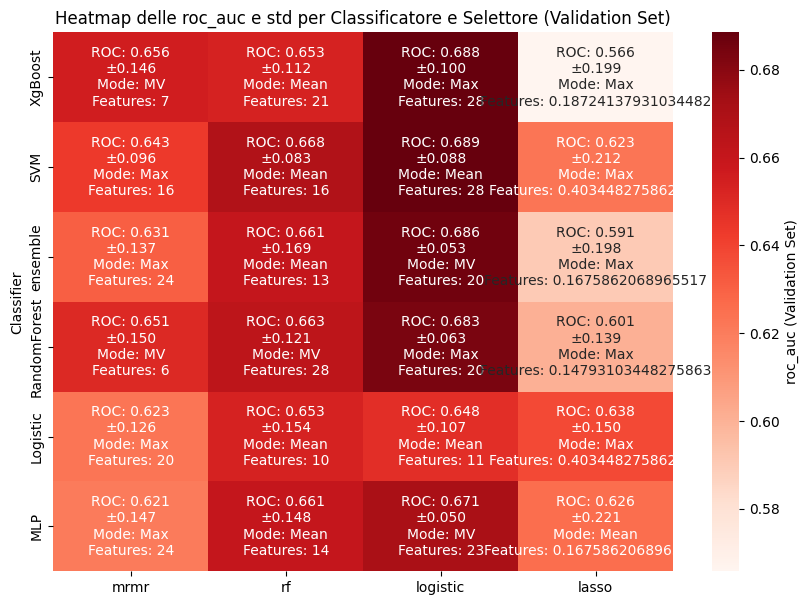

In [133]:
# Inizializza una matrice vuota per memorizzare le performance sul validation set
heatmap_data = pd.DataFrame(index=classifiers, columns=selectors)
annotations = pd.DataFrame(index=classifiers, columns=selectors)

# Popola la matrice con i valori di avg_balaccuracy e annotazioni con std_balaccuracy
for result in best_results_class_selector:
    classifier = result['classifier']
    selector = result['selector']
    
    # Se classifier e selector non sono None, significa che abbiamo un risultato valido
    if classifier is not None and selector is not None:
        # Estrai i valori numerici
        avg_balaccuracy = result[metricaavg]
        std_balaccuracy = result[metricastd]
        mode = result['mode']
        num_features = result['num_features/alpha']
        
        # Inserisci la balanced accuracy del validation set nella heatmap
        heatmap_data.loc[classifier, selector] = avg_balaccuracy
        
        # Inserisci l'annotazione con la balanced accuracy, la deviazione standard, il mode e il numero di features
        annotations.loc[classifier, selector] = (
            f"{labell}: {avg_balaccuracy:.3f}\n"
            f"±{std_balaccuracy:.3f}\n"
            f"Mode: {mode}\n"
            f"Features: {num_features}"
        )

# Riempi i valori NaN con 0 (se necessario)
heatmap_data = heatmap_data.astype(float).fillna(0)

# Crea la heatmap con annotazioni
plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="Reds", cbar_kws={'label': f'{metricanome} (Validation Set)'})
plt.title(f"Heatmap delle {metricanome} e std per Classificatore e Selettore (Validation Set)")
plt.ylabel('Classifier')
plt.show()


### heatmap test

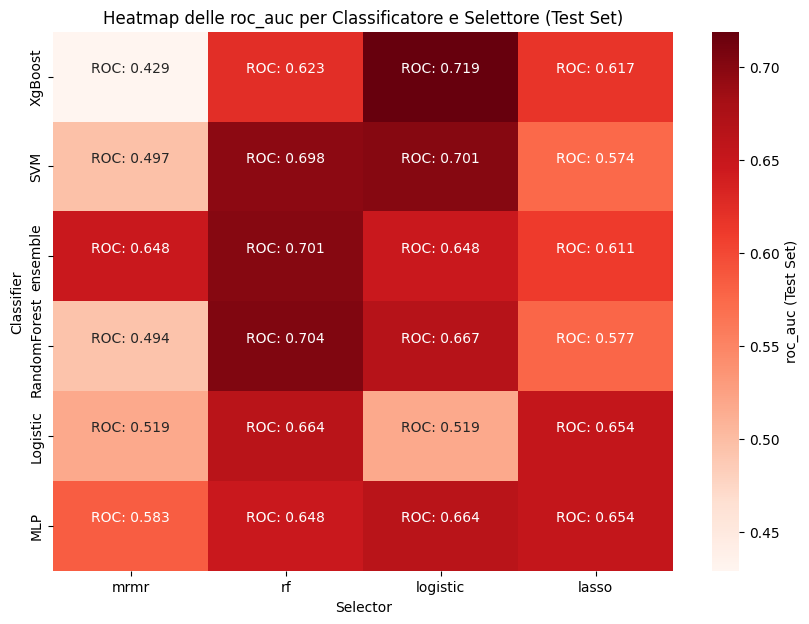

In [134]:
# Inizializza una matrice vuota per memorizzare le performance sul validation set
heatmap_data = pd.DataFrame(index=classifiers, columns=selectors)
annotations = pd.DataFrame(index=classifiers, columns=selectors)

# Popola la matrice con i valori di avg_balaccuracy e annotazioni con std_balaccuracy
for result in best_results_class_selector_test:
    classifier = result['classifier']
    selector = result['selector']
    
    # Se classifier e selector non sono None, significa che abbiamo un risultato valido
    if classifier is not None and selector is not None:
        # Estrai i valori numerici
        balaccuracy = result[metricanome]

        # Inserisci la balanced accuracy del validation set nella heatmap
        heatmap_data.loc[classifier, selector] = balaccuracy
        
        # Inserisci l'annotazione con la balanced accuracy, la deviazione standard, il mode e il numero di features
        annotations.loc[classifier, selector] = (
            f"{labell}: {balaccuracy:.3f}\n"
      
        )

# Riempi i valori NaN con 0 (se necessario)
heatmap_data = heatmap_data.astype(float).fillna(0)


# Crea la heatmap con Balanced Accuracy e annotazioni personalizzate
plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="Reds", cbar_kws={'label': f'{metricanome} (Test Set)'})
plt.title(f"Heatmap delle {metricanome} per Classificatore e Selettore (Test Set)")
plt.ylabel('Classifier')
plt.xlabel('Selector')
plt.show()